# Project 3: Reddit AirBnb vs ShoeString

---
## Problem Statement

Airbnb is one of the world’s largest marketplaces for unique, authentic places to stay and things to do, offering over 7 million accommodations and 50,000 handcrafted activities, all powered by local hosts. An economic empowerment engine, Airbnb has helped millions of hospitality entrepreneurs monetize their spaces and their passions while keeping the financial benefits of tourism in their own communities.

To be able to differentiate itself from the competitors, it has to constantly review and monitor the messaging that is being communicated corporately, as well as the messaging that is used in the social media. In this notebook, we will be looking at the posts on Reddit, which a network of communities based on people's interests. <br>
Specifically we will be looking at these 2 subreddits:
- r/AirBnB
- r/ShoeString (Travel on a Shoestring Budget)

This is the pilot project into analyzing Posts in reddit, and the main objective is to gauge if AirBnB is being perceived as being a purely budget lodging option. We will be training classification models Logistic Regression and MultinormialNB to determine which subreddit a post is from. The high False Negatives and False Positives rate would potentially mean that there is no clear distinction between AirBnB and ShoeString. We are looking at selecting the model with a minimum of 95% accuracy.

---
## Executive Summary

In this notebook we will be looking to pair these Vectorizers; Count Vectorizer, Hashing Vectorizer
and Tfidf Vectorizer with LogisticRegresion, BernoulliNB and MultinomialNB. After analysis, the 2 best performing pairing was Hashing Vectorizer with MultinomialNB and Tfidf Vectorizer with LogisticRegression. Between these 2 pairs, the final selection is Tfidf Vectorizer with LogisticRegression, as:
- It is slightly better in terms of overfitting
- It has similar scores with lesser features when compared to MultinomialNB
- False negatives and False positives rates are pretty close as well. 

The false positives, posts that are classified as AirBnB but were actually ShoeString posts. <br>
The false negatives, posts that are classified as ShoeString but were actually AirBnB posts. <br>
There are 22 false negatives and 13 false positives out of 1824 posts, 98% of the posts were classified correctly. <br> Looking at these misclassifications, most of them were general comment/enquiry type of posts so they are still within expectation of 95% accuracy.

---
### Contents:
- [Data Import & Preprocessing](#Data-Import-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-data)
- [Modelling](#Modelling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Import and Preprocessing

---
Importing python libraries

In [1]:
#Imports:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import time
import random
import warnings
import requests
import regex as re
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix

In [2]:
#setting options for both pandas and numpy to show decimals up to 4 places
pd.set_option('display.precision',4)
np.set_printoptions(precision=4)
%precision 4
%matplotlib inline

In [3]:
#suppress MarkupResemblesLocatorWarning from Beautifulsoup
warnings.simplefilter(action='ignore', category=MarkupResemblesLocatorWarning)
# Setting the colwidth to max to read the full text
pd.set_option('display.max_colwidth', None)

In [4]:
# Defining a dict to hold the filenames.
# Reason for this is for the ease of changing the filenames and path,
# without changing any other codes
data_files = {
    'airbnb' : '../data/airbnb.csv',
    'shoestring' : '../data/shoestring.csv',
    'mask' : '../image/cloud.jpg'
}

In [5]:
# Defining a list of dict to hold the information for each reddit topic
topics = {
    'airbnb' : {
            'url': 'https://www.reddit.com/r/Shoestring.json',
            'filename': data_files['shoestring']
        },
    'shoestring' : {
            'url': 'https://www.reddit.com/r/AirBnB.json',
            'filename': data_files['airbnb']
        }
}

In [6]:
# DEBUG flag to turn on or off debug messages
DEBUG = False
debug = lambda t : print(t) if DEBUG else None

---
### Function for calling Reddit API

In [7]:
# function to call reddit api
def call_reddit_api(topics, loop=40):
    """ 
    function to call reddit api 
  
    Parameters: 
		topics (list): List of subreddits to use for the api calls
        loop (int): number of api calls per topic 
  
    Returns: 
		None
  
    """
    # list of user_agents to be used for http get request to reddit
    user_agents = [
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    ]
    
    # loop through the topics list
    for i in topics.keys():
        url = topics[i]['url']
        filename = topics[i]['filename']
        posts = []
        after = None
        debug(f'>>> topic:{filename[:-4]} filename:{filename}')

        # number of request for each topic
        # looking to get ~1K posts so ~ 40 requests 
        # at 25 posts per request
        for a in range(loop+1):
            # pick a random user_agent, to prevent getting blocked by reddit
            user_agent = np.random.choice(user_agents, size=1, replace=True)
            headers = {'User-agent': user_agent[0]}

            # append url params for subsequent posts
            current_url = url if after==None else url + '?after=' + after
            debug(f'run:{a} url:{current_url}')
            
            # api call to reddit
            res = requests.get(current_url, headers=headers)

            # if request is not successful break from loop
            if res.status_code != 200:
                debug(f'run:{a} Status error:{res.status_code}')
                break

            # convert json response into python list
            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']]
            posts.extend(current_posts)
            after = current_dict['data']['after']

            # write posts to files
            if a > 0:
                prev_posts = pd.read_csv(filename)
                debug(f'run:{a} shape:{prev_posts.shape}')
                current_df = pd.DataFrame(current_posts)
                all_posts = pd.concat([prev_posts, 
                                      current_df[~current_df['name'].isin(prev_posts['name'])]])
                all_posts.to_csv(filename, index = False) 
            else:
                pd.DataFrame(posts).to_csv(filename, index = False)

            # break from loop when there are no more posts
            if after == None:
                debug(f'run:{a} after==None, ending api calls')
                break

            # generate a random sleep duration to prevent flooding reddit
            sleep_duration = random.randint(3,60)
            debug(f'run:{a} after:{after} sleep:{sleep_duration}\n')
            time.sleep(sleep_duration)
    
    return

In [8]:
# GET_REDDIT flag to run call_reddit_api or not
# Set to False as the subreddits has been saved into csv files
GET_REDDIT = False 

In [9]:
# execute function to call reddit api
if GET_REDDIT: call_reddit_api(topics)

---
## Read AirBnB posts from file

In [10]:
air_df = pd.read_csv(data_files['airbnb'])

In [11]:
air_df.shape

(889, 106)

---
## Read ShoeString posts from file

In [12]:
shoe_df = pd.read_csv(data_files['shoestring'])

In [13]:
shoe_df.shape

(935, 111)

---
## Exploratory Data Analysis
[top](#Executive-Summary)

Check for duplicates in both DataFrame

In [14]:
print(f'Duplciated post count for AirBnB: {air_df.duplicated().sum()}')
print(f'Duplciated post count for ShoeString: {shoe_df.duplicated().sum()}')

Duplciated post count for AirBnB: 0
Duplciated post count for ShoeString: 0


---
Concatenate the 2 sets of posts into one DataFrame

In [15]:
# making a copy of the DataFrame with reduced features
air = air_df[['subreddit', 'name', 'title', 'selftext', 'created', 'num_comments']].copy()
shoe = shoe_df[['subreddit', 'name', 'title', 'selftext', 'created', 'num_comments']].copy()
# merging both the DataFrames into one 
df = pd.concat([air, shoe], ignore_index=True)

---
#### Converting the created timestamp into datetime

In [16]:
# converting the created time to datetime
df['created'] = pd.to_datetime(df['created'], unit='s')

Create a new label with 0 for ShoeString and 1 for AirBnB

In [17]:
df['label'] = df['subreddit'].map({'Shoestring': 0, 'AirBnB': 1})

Quick look at the baseline for this dataset

In [18]:
df['label'].value_counts(normalize=True)

0    0.5126
1    0.4874
Name: label, dtype: float64

Checking for null values, we have 68 nulls in the selftext column in total. <br>
AirBnB has 15 null values in selftext column and Shoestring has 53 null values. <br>
Will be keeping them, as we will be using both the title and selftext for this analysis.

In [19]:
df[df['subreddit']=='AirBnB'].isnull().sum()

subreddit        0
name             0
title            0
selftext        15
created          0
num_comments     0
label            0
dtype: int64

In [20]:
df[df['subreddit']=='Shoestring'].isnull().sum()

subreddit        0
name             0
title            0
selftext        53
created          0
num_comments     0
label            0
dtype: int64

Those with null in selftext column have the content/text in the title.<br>

In [21]:
df[df['selftext'].isnull()][['subreddit','title']]

,subreddit,title
24,AirBnB,"Is it feasible that my family can somehow get a 4 bedroom place in Northern Virginia/DC for less than 2000, a month for at least a month by Monday? If not, we will have to go to Extended Stay and there is 5 of us. Plz Help."
41,AirBnB,Airbnb Customer Service is the worst! Rant here!
89,AirBnB,Expensive lesson learned. Never schedule check-out and check-in on the same day.
148,AirBnB,Vrbo owner false claim
238,AirBnB,"Is there a possibility to view basic statistics of specific properties? Like, there’s a property in the area and there are barely any dates available. But I am curious wether it is actually rented out or if the host didn’t offer availabilities."
...,...,...
1748,Shoestring,10 days in Jordan on a budget?
1778,Shoestring,Where should i take a day trip to on new years eve(which is also my birthday) just wanna get away from the fam
1789,Shoestring,Planning a trip to NC
1795,Shoestring,Is $6000 enough for 4 months in Europe?


---
### Cleaning the text data in title and self text

In [22]:
# Function to clean the raw text collected from the web
def clean_text(df, cols, stem=True):
    """ 
    Function to clean the raw text collected from the web
  
    Parameters: 
        df (DataFrame): Dataframe holding the data 
		cols (list): List of cols that needs to be cleaned
        stem (bool): Flag to use stemming or lemmatization
  
    Returns: 
		None:
  
    """
    for col in cols:
        for index, row in df[col].items():
            # Check if the row is NaN
            if not row is np.NaN: 
                # Remove HTML
                review_text = BeautifulSoup(row, 'lxml').get_text()
                debug(f'review_text:\n{review_text}')
                df.loc[index, f'{col}_len'] = len(review_text)

                # Remove non-letters
                words_only = re.sub("[^\w]", " ", review_text)
                debug(f'remove punc:\n{words_only}')
                words_only = re.sub("(\r\n|\r|\n)", "", words_only)
                debug(f'remove newl:\n{words_only}')
                words_only = re.sub("\w*\d\w*", "", words_only)
                debug(f'remove newl:\n{words_only}')

                # Convert to lower case, split into individual words
                words = words_only.lower().split()
                df.loc[index, f'{col}_word_cnt'] = len(words)
                df.loc[index, f'{col}_uniq_cnt'] = len(set(words))

                # Remove stopwords
                stops = set(stopwords.words('english'))
                meaningful_words = [w for w in words if w not in stops]

                if stem: # Stem or Lemma for root words
                    p_stemmer = PorterStemmer()
                    root_words = [p_stemmer.stem(w) for w in meaningful_words]
                else:
                    lemmatizer = WordNetLemmatizer()
                    root_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
                df.loc[index, f'{col}_root_cnt'] = len(root_words)
            
                df.loc[index, col] = (" ".join(root_words)).strip()
            else:
                df.loc[index, f'{col}_len'] = 0
                df.loc[index, f'{col}_word_cnt'] = 0
                df.loc[index, f'{col}_uniq_cnt'] = 0
                df.loc[index, f'{col}_root_cnt'] = 0
                df.loc[index, col] = ''
    return

In [23]:
# taking a copy of the original text for comparison
orig_text_df = df[['title', 'selftext']].copy()

In [24]:
# Cleaning the text for title and selftext
clean_text(df, ['title', 'selftext'], stem=False)

---
Analysis of the posts as well as comparing the texts before and after cleaning

In [25]:
# Comparing texts
index=1001
print(f'Original text for index: {index}')
print('=================================================================')
print(orig_text_df['title'][index])
print('=================================================================')
print(orig_text_df['selftext'][index])
print('=================================================================')
print(f'\nCleaned text for index: {index}')
print('=================================================================')
print(df['title'][index])
print('=================================================================')
print(df['selftext'][index])
print('=================================================================')

Original text for index: 1001
Looking for first time travel tips
Going on an 1,800 mile road trip from CA to OH &amp;amp; KY, possibly alone, but probably with a friend. Wondering if anyone has any tips for a first time, big ass road trip. Im open to sleeping in the car and minimizing the time it takes to get there, but im also open to throwing up a tent and taking it one day at a time. All tips &amp;amp; reccomendations are appreciated, thanks

 (Edit) - I realize the title can be read in a manner that assumes I am looking to Time-Travel. I meant travel tips for a first timer, but thanks for making it clear 😂

Cleaned text for index: 1001
looking first time travel tip
going mile road trip ca oh amp ky possibly alone probably friend wondering anyone tip first time big as road trip im open sleeping car minimizing time take get im also open throwing tent taking one day time tip amp reccomendations appreciated thanks edit realize title read manner assumes looking time travel meant travel 

---
Merging the title and selftext into one feature as there are null values in selftext as well as for ease of fitting the models.

In [26]:
df['full_text'] = df['title'] + ' ' + df['selftext'] 

---
Quick analysis of text length and word count created during the clean text execution

In [27]:
# AirBnB describe
df[df['label']==1].describe([]).T

,count,mean,std,min,50%,max
num_comments,889.0,13.9415,19.5117,0.0,7.0,162.0
label,889.0,1.0000,0.0000,1.0,1.0,1.0
title_len,889.0,54.5366,38.3872,4.0,47.0,291.0
title_word_cnt,889.0,9.6153,7.1416,1.0,8.0,55.0
title_uniq_cnt,889.0,9.2002,6.2693,1.0,8.0,45.0
title_root_cnt,889.0,5.6164,3.6880,0.0,5.0,32.0
selftext_len,889.0,895.4713,1034.1347,0.0,608.0,11339.0
selftext_word_cnt,889.0,167.5951,192.7550,0.0,114.0,2122.0
selftext_uniq_cnt,889.0,95.3138,73.6090,0.0,79.0,701.0
selftext_root_cnt,889.0,77.4072,87.5143,0.0,52.0,963.0


In [28]:
# ShoeString describe
df[df['label']==0].describe([]).T

,count,mean,std,min,50%,max
num_comments,935.0,22.7765,32.7703,0.0,10.0,326.0
label,935.0,0.0000,0.0000,0.0,0.0,0.0
title_len,935.0,51.3594,44.9170,5.0,38.0,300.0
title_word_cnt,935.0,8.9358,8.3614,1.0,6.0,60.0
title_uniq_cnt,935.0,8.4759,7.1596,1.0,6.0,49.0
title_root_cnt,935.0,5.5134,4.3379,0.0,4.0,35.0
selftext_len,935.0,612.6481,1182.5924,0.0,404.0,27861.0
selftext_word_cnt,935.0,111.4353,201.9811,0.0,75.0,4733.0
selftext_uniq_cnt,935.0,70.1647,68.7662,0.0,57.0,1210.0
selftext_root_cnt,935.0,55.9701,110.5873,0.0,36.0,2605.0


Analysis on text length and word count between both threads. Exploring if the length and counts can help in classifying the threads. From the plots below, there are no significant difference between the two. 

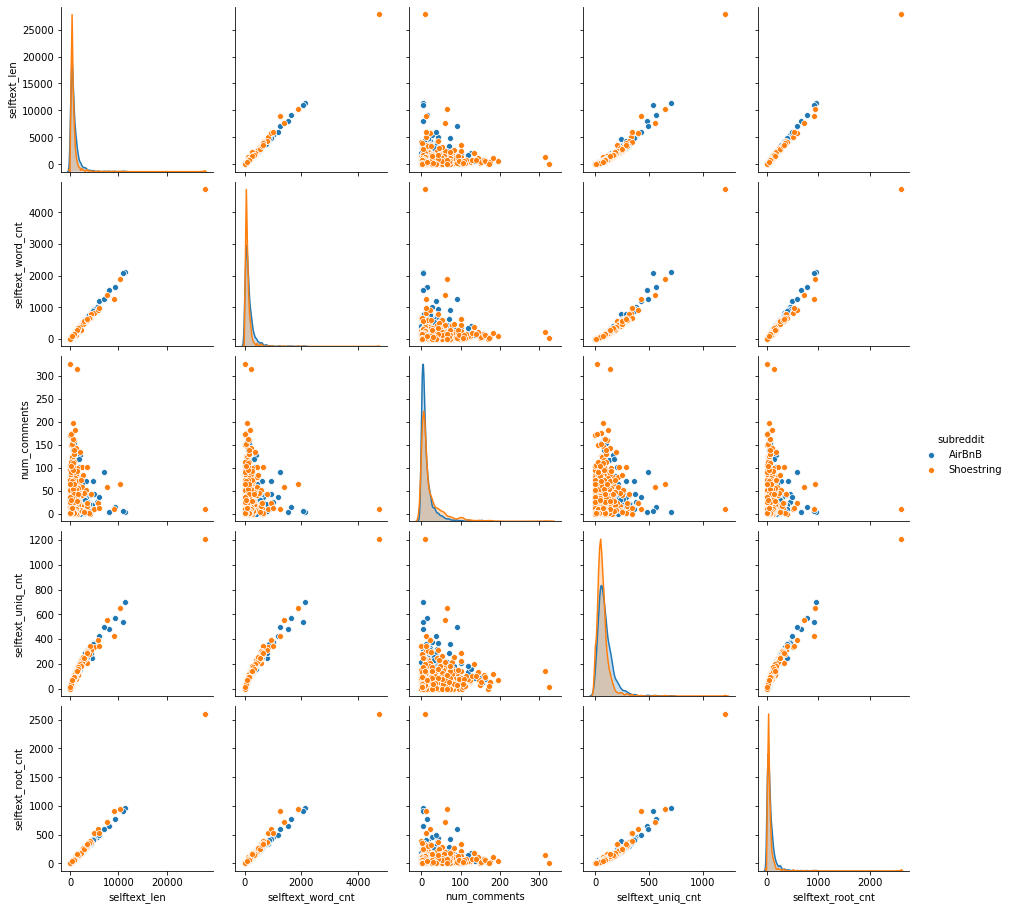

In [29]:
# Plotting the length and counts for both threads
sns.pairplot(
    df[['selftext_len', 'selftext_word_cnt', 'num_comments',
        'selftext_uniq_cnt', 'selftext_root_cnt', 
        'subreddit']], hue="subreddit");

---

## Visualize the data
[top](#Executive-Summary)

In [30]:
# Function to plot wordcloud
def plot_cloud(text, label):
    """ 
    Function to plot wordcloud
  
    Parameters: 
        text (str): Text to be fed into the wordcloud
		label (int): color index for the wordcloud background
  
    Returns: 
		None:
    """
    color = ['skyblue', 'pink']
    # prepare image mask for wordcloud
    mask = np.array(Image.open(data_files['mask']))
    
    # Set figure size
    plt.figure(figsize=(12.1, 7.5))
    # Display image
    plt.imshow(WordCloud(random_state=1, background_color=color[label], 
                      colormap='RdGy', collocations=False, max_words=100,
                      stopwords = STOPWORDS, mask=mask, scale=3).generate(text)) 
    # No axis details
    plt.axis("off");
    return

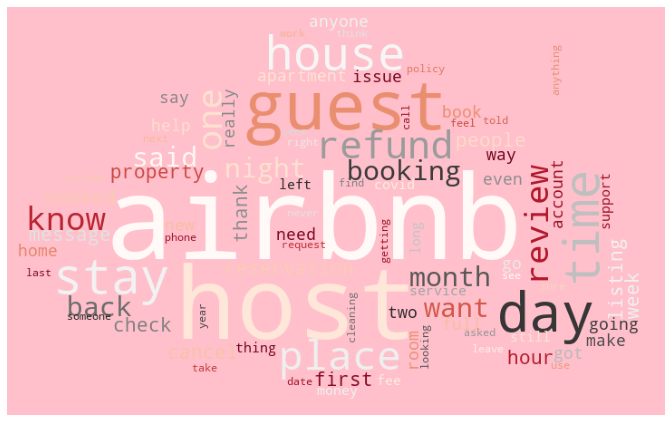

In [31]:
# Plot wordcloud for AirBnB
plot_cloud(df[df['label']==1]['full_text'].to_string(), 1)

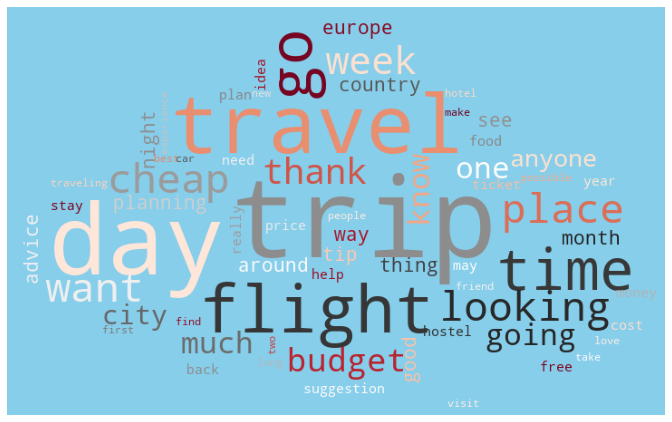

In [32]:
# Plot wordcloud for ShoeString
plot_cloud(df[df['label']==0]['full_text'].to_string(), 0)

In [33]:
# Function to visualize the words in bar plot
def plot_wordcount(label, rows):
    """ 
    Function to visualize the words in bar plot
  
    Parameters: 
        label (int): To filter the label column for airbnb or shoestring
		rows (int): number of words/rows to show on the plot
  
    Returns: 
		None:
    """
    color = ['skyblue', 'pink']
    title = ['ShoeString', 'AirBnB']
    cvec = CountVectorizer(stop_words='english')
    cvec_feats = cvec.fit_transform(df[df['label']==label]['full_text'], df['label'])
    cvec_df = pd.DataFrame(cvec_feats.toarray(), columns = cvec.get_feature_names())
    cvec_df = cvec_df.sum().sort_values().tail(rows)
    cvec_df.plot(kind='barh', figsize=(12, 8), color=color[label])
    plt.title(f'Top {rows} frequently occurring words for {title[label]}', size=16)
    plt.ylabel('Top Words', size=10)
    return

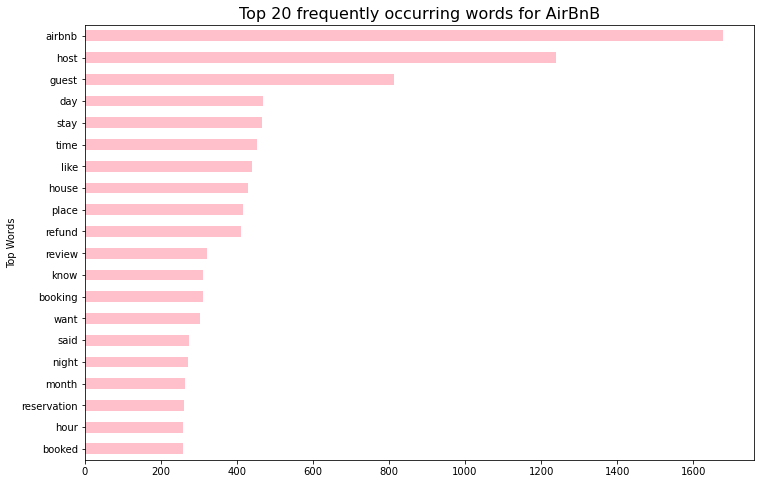

In [34]:
# AirBnB top 20 words
plot_wordcount(1, 20)

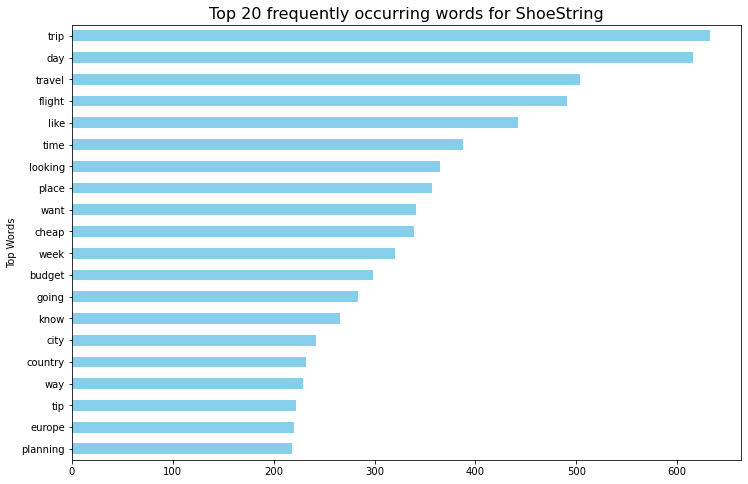

In [35]:
# ShoeString top 20 words
plot_wordcount(0, 20)

After reviewig the wordclouds and bar plots, adding more words into the stop words list. AirBnB is added to this list as well, although this word is the top word used in the AirBnB thread.  The reason is because we want to see how well the classification will still work without using AirBnB. 

In [36]:
# preparing stop words, get default list from CountVectorizer
stop_words = list(CountVectorizer(stop_words = 'english').get_stop_words())
# adding stopwords that are showing up in wordcloud and top 20 list
stop_words.extend(['hi', 'hey', 'hello', 'year', 'day', 'like', 'know', 'airbnb'])

---
## Modelling
[top](#Executive-Summary)

Preparing the variables to be used for modelling

In [37]:
# preparing the featues and target variables
X = df['full_text'].copy()
y = df['label'].copy() 

In [38]:
# Splitting the data into train the test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [39]:
print(f'X_train has {X_train.shape[0]} rows')
print(f'X_test  has {X_test.shape[0]} rows')

X_train has 1368 rows
X_test  has 456 rows


Quick check on the distribution of both topics in train and test

In [40]:
y_train.value_counts(normalize=True)

0    0.5124
1    0.4876
Name: label, dtype: float64

In [41]:
y_test.value_counts(normalize=True)

0    0.5132
1    0.4868
Name: label, dtype: float64

---

In [42]:
# Function to execute combination of vectorizes and estimators
def execute_pipeline(vecs, ests, df, X_train, y_train, X_test, y_test, plot=False, match=None):
    """ 
    Function to execute combination of vectorizes and estimators
  
    Parameters: 
        vecs (dict): dictionary of vectorizes to be used
		ests (dict): dictionary of estimators to be used
        X_train (Series): Series holding the train feature
        y_train (Series): Series holding the train target
        X_test (Series): Series holding the test feature
        y_test (Series): Series holding the test target
        plot (bool): Flag to plot the charts
        match (list): list of tags to execute 
  
    Returns: 
		None:
  
    """
    tags = [] # list to hold the estimators' names
    metrics = [] # list to hold the metrics
    for est_name, est in ests.items():
        for vec_name, vec in vecs.items():
            metric = {}
            tag = f'{est_name}_{vec_name}'
            # skipping when only specific pairs are passed in
            if match!=None and tag not in match:
                continue
            tags.append(tag)

            # instantiate pipeline
            pipe = make_pipeline(vec, est)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            # collect predict for full dataframe for analysis
            df[tag] = pipe.predict(df['full_text'])

            metric['Train score'] = f'{pipe.score(X_train, y_train):,.4f}'
            metric['Test  score'] = f'{pipe.score(X_test, y_test):,.4f}'
            metric['Score diff'] = float(metric['Train score'])-float(metric['Test  score'])
            debug (f'{tag}->Train accuracy score: {metric["Train score"]}')
            debug (f'{tag}->Test accuracy score: {metric["Test  score"]}')

            if isinstance(pipe.steps[0][1], HashingVectorizer):
                metric['No. of features'] = f'{pipe.steps[0][1].n_features:,.0f}'
                debug (f'{tag}->Number of features: {metric["No. of features"]}')
            else:
                metric['No. of features'] = f'{len(pipe.steps[0][1].get_feature_names())}'
                debug (f'{tag}->Number of features: {metric["No. of features"]}')

            # calculate Specificity and Sensitivity
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            metric['Precision'] = f'{(tp /(tp + fp)):.4f}'
            metric['Specificity'] = f'{(tn / (tn + fp)):.4f}'
            metric['Sensitivity'] = f'{(tp / (tp + fn)):.4f}'
            metric['True Negatives'] = tn
            metric['False Positives'] = fp
            metric['False Negatives'] = fn
            metric['True Positives'] = tp
            debug(f'{tag}->Precision: {metric["Precision"]}')
            debug(f'{tag}->Specificity: {metric["Specificity"]}')
            debug(f'{tag}->Sensitivity: {metric["Sensitivity"]}')

            metrics.append(metric)

            if plot:
                # plot roc and confusion matrix
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
                plot_roc_curve(pipe, X_test, y_test, name=tag, ax=ax[0]);
                # Plot baseline. (Perfect overlap between the two populations.)
                ax[0].plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200),
                         label='baseline', linestyle='--')
                plot_confusion_matrix(pipe, X_test, y_test, ax=ax[1], cmap='RdPu');
                ax[0].set_title(f'ROC for {tag}');
                ax[1].set_title(f'Confusion Matrix for {tag}');
                

    # convert metrics into a DataFrame
    metrics = pd.DataFrame(metrics).T
    metrics.columns = tags
    return metrics

In [43]:
# Dictionary of vectors
vectors = {
    'hash': HashingVectorizer(stop_words=stop_words,
                              alternate_sign=False,
                              n_features=2**16),
    'count': CountVectorizer(stop_words=stop_words),
    'tfidf': TfidfVectorizer(stop_words=stop_words,
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000)
}

In [44]:
# Dictionary of estimators
estimators = {
    'log': LogisticRegression(),
    'bnb': BernoulliNB(),
    'mnb': MultinomialNB()
}

In [45]:
# toggle debug to True if require to view debug prints
DEBUG = False
# execute through the combination of vectors and estimators for the most promising pair 
execute_pipeline(vectors, estimators, df, X_train, y_train, X_test, y_test)

,log_hash,log_count,log_tfidf,bnb_hash,bnb_count,bnb_tfidf,mnb_hash,mnb_count,mnb_tfidf
Train score,0.9854,1.0000,0.9861,0.9159,0.9488,0.9430,0.9810,0.9846,0.9730
Test score,0.9539,0.9539,0.9605,0.8640,0.9101,0.9189,0.9605,0.9561,0.9518
Score diff,0.0315,0.0461,0.0256,0.0519,0.0387,0.0241,0.0205,0.0285,0.0212
No. of features,"65,536",8655,1000,"65,536",8655,1000,"65,536",8655,1000
Precision,0.9718,0.9718,0.9679,0.9878,0.9738,0.9744,0.9722,0.9676,0.9630
Specificity,0.9744,0.9744,0.9701,0.9915,0.9786,0.9786,0.9744,0.9701,0.9658
Sensitivity,0.9324,0.9324,0.9505,0.7297,0.8378,0.8559,0.9459,0.9414,0.9369
True Negatives,228,228,227,232,229,229,228,227,226
False Positives,6,6,7,2,5,5,6,7,8
False Negatives,15,15,11,60,36,32,12,13,14


After pairing the vectorizers against the estimators. <br>
As we are looking for the lowest count in False Negatives and False Positives. <br>
The top 2 pairings are:
- LogisticRegression with Tfidf <br>
- MultinomialNB with Hashing. <br>

Next step is to use GridSearch to see if tuning the hyperparameters will give a better score.

---
#### Using GridSearch to tune hyperparameters

In [46]:
# Function to init and fit GridSearch
def grid_wrapper(pipe, params, X_train, y_train, X_test, y_test):
    """ 
    # Function to init and fit GridSearch
  
    Parameters: 
        pipe (Pipeline): pipeline of vectorizers and estimator
		params (dict): dictionary of hyperparameters to be used
        X_train (Series): Series holding the train feature
        y_train (Series): Series holding the train target
        X_test (Series): Series holding the test feature
        y_test (Series): Series holding the test target
  
    Returns: 
		GridSearch
  
    """
    # Instantiate our GridSearchCV object.
    gs = GridSearchCV(pipe, pipe_params, cv=5)
    gs.fit(X_train, y_train)
    
    debug(f'best estimator: {gs.best_estimator_}')
    print(f'best params: {gs.best_params_}')
    print(f'test score: {gs.score(X_test, y_test):.4f}')
    return gs

---
Tuning hyperparamters for Tfidf + LogisticRegression pair

In [47]:
# Instantiate Pipeline for Tfidf + LogisticRegression.
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('log', LogisticRegression())
])

In [48]:
# Define dictionary of hyperparameters.
pipe_params = {
    'tfidf__max_features' : [1000],
    'tfidf__max_df' : [0.5],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__sublinear_tf': [True, False],
    'log__solver' : ['lbfgs', 'saga']
}

In [49]:
# Grid Search
log_gs = grid_wrapper(pipe, pipe_params, X_train, y_train, X_test, y_test)

best params: {'log__solver': 'saga', 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': False}
test score: 0.9627


Slight improvment to the score. Will use this hyperparameters for the comparison with MultinomialNB.

---
Tuning hyperparamters for Hashing + MultinomialNB pair

In [50]:
# Instantiate Pipeline for Hashing + MultinomialNB.
pipe = Pipeline([
    ('hash', HashingVectorizer(stop_words=stop_words, alternate_sign=False)),
    ('mnb', MultinomialNB())
])

In [51]:
# Define dictionary of hyperparameters.
pipe_params = {
    'hash__n_features' : [2**16, 2**17],
    'mnb__fit_prior' : [True, False],
    'mnb__alpha' : [0.25, 0.5]
}

In [52]:
# Grid Search
hash_gs = grid_wrapper(pipe, pipe_params, X_train, y_train, X_test, y_test)

best params: {'hash__n_features': 131072, 'mnb__alpha': 0.25, 'mnb__fit_prior': False}
test score: 0.9627


---
#### Anaylsis of the models after tuning the hyperparameters

In [53]:
# Dictionary of vectors
vectors = {
    'hash': HashingVectorizer(stop_words=stop_words,
                              alternate_sign=False,
                              n_features=2**17),
    'tfidf': TfidfVectorizer(stop_words=stop_words,
                                      sublinear_tf=False,
                                      max_df=0.5,
                                      ngram_range=(1, 2),
                                      max_features=1000)
}

In [54]:
# Dictionary of estimators
estimators = {
    'mnb': MultinomialNB(alpha=0.25, fit_prior=False),
    'log': LogisticRegression(solver='lbfgs')
}

,mnb_hash,log_tfidf
Train score,0.9890,0.9868
Test score,0.9627,0.9627
Score diff,0.0263,0.0241
No. of features,"131,072",1000
Precision,0.9680,0.9724
Specificity,0.9701,0.9744
Sensitivity,0.9550,0.9505
True Negatives,227,228
False Positives,7,6
False Negatives,10,11


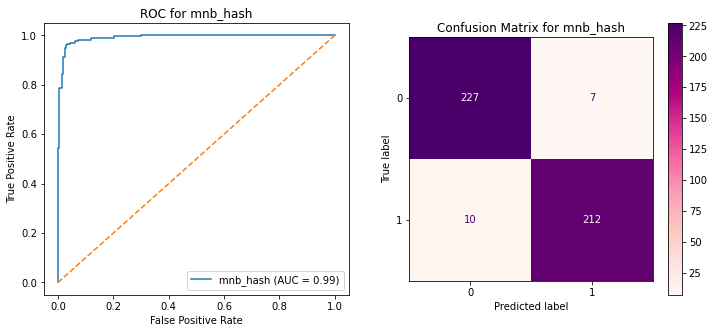

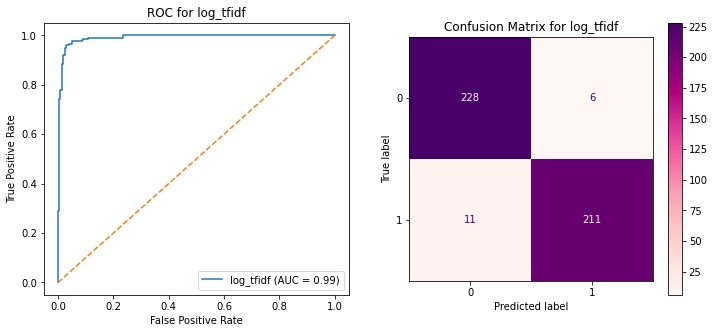

In [55]:
# toggle debug to True if require to view debug prints
DEBUG = False
# execute the vector estimator pair, to get predictions and plots
execute_pipeline(vectors, estimators, df, X_train, y_train, X_test, y_test, True, ['mnb_hash', 'log_tfidf'])

After hyperparameter tuning, the performance for both are very close. <br>
In this case, will be selecting Logistics Regression with Tfidf for deployment as:
- It is slightly better in terms of overfitting
- It has similar scores with lesser features when compared to MultinomialNB
- False negatives and False positives rates are pretty close as well. 

---
Looking at the words that have most impact to classification

In [56]:
# merging the words and coef from the vectorizer and estimator
feats_df = pd.DataFrame({
    'words' : vectors['tfidf'].get_feature_names(),
    'coef' : np.exp(estimators['log'].coef_[0])
})

# retrieving top words for both topics
air_words = feats_df.sort_values(by='coef').tail(20)
shoe_words = feats_df.sort_values(by='coef').head(20)

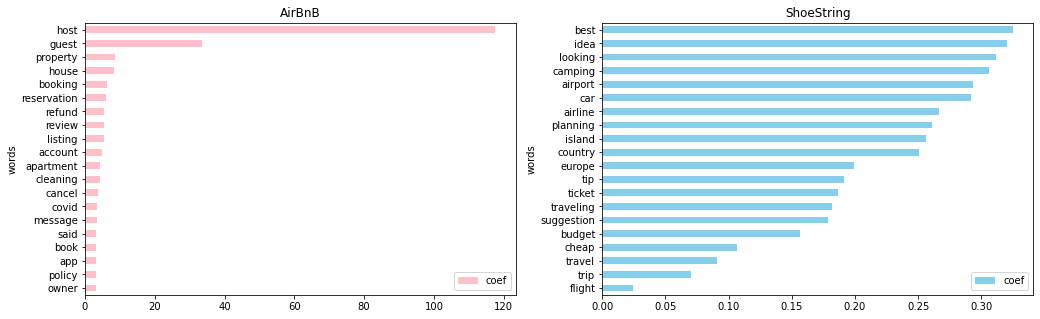

In [57]:
# plotting out the words that have the most impact to the classification
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
air_words.plot(x='words', y='coef', kind='barh', title='AirBnB', color='pink', ax=ax[0]);
shoe_words.plot(x='words', y='coef', kind='barh', title='ShoeString', color='skyblue', ax=ax[1]);

---
#### Analysis of misclassification 

In [58]:
# analysis of false negatives from log_tfidf
filter_mask = ((df['label']==1) & (df['log_tfidf']==0))
misclass_df = df[filter_mask][['title', 'selftext', 'label', 'log_tfidf', 'mnb_hash']]
print(f'Number of False Negatives misclassifications when using log_tfidf is {misclass_df.shape[0]}')
misclass_df.head()

Number of False Negatives misclassifications when using log_tfidf is 22


,title,selftext,label,log_tfidf,mnb_hash
27,anyone know awesome place colorado montana group,hey everyone friend group wanting plan trip next summer group people depending couple make live midwest right really specific destination go looking idea state included search colorado montana top also dakota iowa minnesota wisconsin two work big hiking really looking western state limited know montana amazing large cabin near solid hiking spot mountain huge partiers enjoy socializing host would worry getting rowdy anything lastly like sortaaaaa near mid big city tourist aspect needed like go around try local shop restaurant bar town offer found couple dakota colorado montana definitely like seeing guy solid recommendation stayed sure price matter collectively week looking u thanks everyone,1,0,0
49,reminiscing past trip share experience gift card,obviously rough time airbnb travel right trying combat cabin fever looking back old vlogs usually compile short video clip traveling ad stitch together music return curious people tend reminisce trip past help evoke memory strongly also note friend design student working personal project envision airbnb could better help traveler curate memory connect host currently conducting interview gift card token appreciation time interested please fill following survey http form gle http form gle,1,0,1
147,anyone monitor airbnb competition,anyone monitor airbnb competition,1,0,1
168,help getting full refund,husband suppose leave europe july work trip come back early october obviously thing cancelled due covid booked airbnb germany oktoberfest soon found going europe heard hard find something around area short notice date finally fall airbnb spot u cancel want specific screenshots requirement screenshot official government site explaining restriction prevent travel location destination effective date restriction must fall within week check date note travel advisory prohibit travel sufficient booked stay september hard time finding government site requirement help would appreciated,1,0,1
235,traveling colorado book airbnb,hello partner want visit colorado go rocky would best place choose airbnb,1,0,0


Looking at the false negatives, posts that are classified as ShoeString but were actually AirBnB posts. <br>
There are a 22 false negatives out of 1824 posts. Looking at these 22 posts, most of them were general enquiry type of posts, that were not AirBnB related. There are also some that posts that are short and would have been classified correctly if AirBnB wasn't in the stop words list. These false negatives are still within expectation and are not contributing to the perception that AirBnB is budget.

---

In [59]:
# analysis of false positives from log_tfidf
filter_mask = ((df['label']==0) & (df['log_tfidf']==1))
misclass_df = df[filter_mask][['title', 'selftext', 'label', 'log_tfidf', 'mnb_hash']]
print(f'Number of False Positives misclassifications when using log_tfidf is {misclass_df.shape[0]}')
misclass_df.head()

Number of False Positives misclassifications when using log_tfidf is 13


,title,selftext,label,log_tfidf,mnb_hash
987,hostelworld survey,got free credit minute survey hostelworld imagine everyone get email everyone read email probably check get night place,0,1,1
991,negotiating hotel price day,anyone success negotiating hotel price day stay considering staycation town weekend wondering calling luxury hotel tomorrow afternoon see deal vacant room night anyone tried success room online still listed normal pre covid price seem lot vacancy currently,0,1,1
995,brussels sofia help needed,trying link two workaways form one large holiday july need leave brussels july get sofia date kinda flexible plane train bother aint fussed paying stay random city night two,0,1,0
1045,book rental car,many day book rental car usually use enterprise like surprise fee anyone used turo,0,1,1
1100,today got per night booking nearest capital city,reason hostel city listed per person rate per room rate one person private room essentially meaning could book mate week away price one person essentially applying discount found look saving deal tab looking private room sorry brag think would find little win today neat anything like happen love hear major minor win like,0,1,1


Looking at the false positives, posts that are classified as AirBnB but were actually ShoeString posts. <br>
There are a 13 false positives out of 1824 posts. Looking at these 13 posts, most of them were general comment type of posts, that mentioned 'book' and 'room' thus classified as AirBnB. These would have been classified correctly if AirBnB wasn't in the stop words list. These false postives are still within expectation.

---
## Conclusions and Recommendations
[top](#Executive-Summary)

### Conclusion
In this notebook we have looked at pairing Count Vectorizer, Hashing Vectorizer and Tfidf Vectorizer with LogisticRegresion, BernoulliNB and MultinomialNB. The 2 best performing pairing was Hashing Vectorizer with MultinomialNB and Tfidf Vectorizer with LogisticRegression. Between these 2 pairs, the final selection is Tfidf Vectorizer with LogisticRegression, as this combination:
- Is slightly better in terms of overfitting
- Has similar scores with lesser features when compared to MultinomialNB
- False negatives and False positives rates are pretty close as well. 

Although we have added AirBnB into the stop word list we were still able to achieve a test score of 96.27%. Thus we are happy with the results and will continue to leave the word in the stop word list.

The false positives, posts that are classified as AirBnB but were actually ShoeString posts. <br>
The false negatives, posts that are classified as ShoeString but were actually AirBnB posts. <br>
There are 22 false negatives and 13 false positives out of 1824 posts. Looking at these misclassifications, <br>most of them were general comment/enquiry type of posts so they are still within expectation of 95% accuracy.

### Recommendations
For the future phase of the project, in order to get more indepth analysis of these threads, we can do the following:
- Dive into analysis of the comments as well, as we have only looked into the main post in this notebook.
- Analysis of the sentence structure where AirBnB word appears in relation to cheap accommodations.
- Part of Speech tagging, to analyze the context and definition of the words within the posts.
- Sentiment analysis on the posts, especially when there are an increase in negative posts.
- Use Principal component analysis to analyze the threads

